# Intro to TensorFlow
 - Basic models over MNIST dataset
   - Linear model
   - NN one layer node
   - Convolutional model
 - Tensoboard example
 - Save & load models

In [1]:
# Header
# Basic libraries & options
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


/Users/jorge/anaconda3/envs/tm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version:  1.7.0


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16214802234297272380
]


## Get the MNIST data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/mnist', one_hot=True)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Train shape:  (55000, 784)
Valid shape:  (5000, 784)
Test  shape:  (10000, 784)


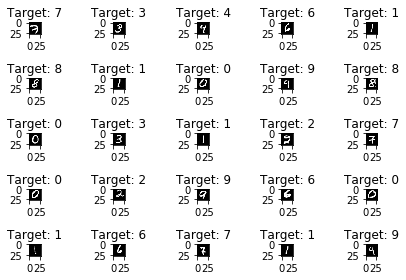

In [4]:
#Examine the data
print('Train shape: ', mnist.train.images.shape)
print('Valid shape: ', mnist.validation.images.shape)
print('Test  shape: ', mnist.test.images.shape)

fig = plt.figure()
for i in range(25):
    a = fig.add_subplot(5,5,i+1)
    a.set_title('Target: ' + str(np.argmax(mnist.train.labels[i])))
    fig.tight_layout()
    plt.imshow( np.reshape(mnist.train.images[i],(28,28)) )



## Fist model: Linear model
 - Start an interactive session
 - Define the graph
 - Train the graph
   - Initialize variables
   - Loop over the data runing the trainer
 - Validate model with test accuracy

In [5]:
# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


In [6]:
### Define the graph
# - Placeholders
# - Model
# - Loss
# - Trainer

# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])


#------------------------------------
#-----------   MODEL  ---------------
#------------------------------------
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
y_pred = tf.nn.softmax(tf.matmul(x,W) + b)
#------------------------------------


# Loss
cross_entropy = -tf.reduce_sum(y * tf.log(y_pred))

# Trainer
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)


In [7]:
### Train the graph
# Intialize vars
sess.run(tf.global_variables_initializer())

In [8]:
# Iterate running the trainer
batch_size = 128
num_epoch = 50
for epoch in range(num_epoch):
    for i in range(430):  # 215 * batch_size is aprox the train size (55000)
        batch = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict={x: batch[0], y: batch[1]})

In [9]:
# Predict and evaluate    
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Test accuracy: ', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Test accuracy:  0.9263


In [10]:
#When finish, close the interactive session
sess.close()

# Reset the graph to the next experiments
tf.reset_default_graph()

## Model 2: Neural network model
 - Add a dense layer between the inputs & the output

In [11]:
def dense_layer(x, input_dim=10, output_dim=10, name='dense'):
    '''
    Dense layer function
    Inputs:
      x: Input tensor
      input_dim: Dimmension of the input tensor.
      output_dim: dimmension of the output tensor
      name: Layer name
    '''
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1), name='W_'+name)
    b = tf.Variable(tf.constant(0.1, shape=[output_dim]), name='b_'+name)
    dense_output = tf.nn.relu(tf.matmul(x, W) + b)
    return dense_output

In [12]:
# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


### Define the graph

# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])


#------------------------------------
#-----------   MODEL  ---------------
#------------------------------------
# First layer
dense_1 = dense_layer(x, input_dim=784, output_dim=500, name='dense1')

# Final layer
dense_2 = dense_layer(dense_1, input_dim=500, output_dim=10, name='dense2')
#------------------------------------

# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=dense_2, labels=y)

#Optimizer
train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)


# Predict and evaluate    
y_pred = tf.nn.softmax(dense_2)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


### Train the graph
# Intialize vars
sess.run(tf.global_variables_initializer())


# Iterate running the trainer
batch_size = 128
num_epoch = 30
for epoch in range(num_epoch):
    for i in range(430):  # 430 * batch_size is aprox the train size (55000)
        batch = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict={x: batch[0], y: batch[1]})
    print('Epoch: ',epoch,' - Accuracy: ', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

print('Test accuracy: ', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    

#When finish, close the interactive session
sess.close()
tf.reset_default_graph()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch:  0  - Accuracy:  0.3829
Epoch:  1  - Accuracy:  0.5818
Epoch:  2  - Accuracy:  0.6723
Epoch:  3  - Accuracy:  0.6824
Epoch:  4  - Accuracy:  0.6851
Epoch:  5  - Accuracy:  0.6862
Epoch:  6  - Accuracy:  0.6878
Epoch:  7  - Accuracy:  0.6897
Epoch:  8  - Accuracy:  0.6893
Epoch:  9  - Accuracy:  0.6873
Epoch:  10  - Accuracy:  0.6866
Epoch:  11  - Accuracy:  0.6863
Epoch:  12  - Accuracy:  0.6868
Epoch:  13  - Accuracy:  0.6879
Epoch:  14  - Accuracy:  0.6872
Epoch:  15  - Accuracy:  0.687
Epoch:  16  - Accuracy:  0.6841
Epoch:  17  - Accuracy:  0.6856
Epoch:  18  - Accuracy:  0.6882
Epoch:  19  - Accuracy:  0.6887
Epoch:  20  - Accuracy:  0.689
Epoch:  21  - Accuracy:  0.6847
Epoch:  22  - Accuracy:  0.6866
Epoch:  23  - Accuracy:  0.6869
Epoch:  24  - Accuracy:  0.6871
Epoch:  25  - Accuracy:

## Model 3: Convolutional model
 - Add 2 convolution and max pooling layers previous to the dense layers
 - Add a dropout regularization layer in the first dense layer

In [13]:
def conv_layer(x, size=2, input_channels=1, output_channels=32, name='conv'):
    '''
    Function to configure a convolution layer
    Inputs:
      x: Input tensor
      size: Convolution filter size x size
      input_channels: Num of input channels
      output_channels: Num of output channels
    '''
    W_conv = tf.Variable(tf.truncated_normal([size, size, input_channels, output_channels], stddev=0.1), name='W_'+name)
    b_conv = tf.Variable(tf.constant(0.1, shape=[output_channels]), name='b_'+name)
    conv_out = tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='SAME') + b_conv)
    return conv_out

In [14]:
# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

#Create the net
# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])


#------------------------------------
#-----------   MODEL  ---------------
#------------------------------------
#Reshape input data to the original image shape
x_image = tf.reshape(x, [-1,28,28,1])

# First convolution
h_conv1 = conv_layer(x_image, size=5, input_channels=1, output_channels=20, name='conv1')
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print('Conv - pool 1: ', h_pool1)

#Second convolution
h_conv2 = conv_layer(h_pool1, size=5, input_channels=20, output_channels=50, name='conv2')
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
print('Conv - pool 2: ', h_pool2)

#First dense layer
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*50])
h_fc1 = dense_layer(h_pool2_flat, input_dim=7*7*50, output_dim=500, name='dense1')
print('Dense 1: ', h_fc1)

#Dropout 
dropout_keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, dropout_keep_prob)

#Second dense layer
h_fc2 = dense_layer(h_fc1_drop, input_dim=500, output_dim=10)
print('Dense 2: ', h_fc2)

#Prediction
y_pred = tf.nn.softmax(h_fc2)
#------------------------------------


# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=h_fc2, labels=y, name='cross_entropy')

#Optimizer
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

#Accuracy
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Conv - pool 1:  Tensor("MaxPool:0", shape=(?, 14, 14, 20), dtype=float32)
Conv - pool 2:  Tensor("MaxPool_1:0", shape=(?, 7, 7, 50), dtype=float32)
Dense 1:  Tensor("Relu_2:0", shape=(?, 500), dtype=float32)
Dense 2:  Tensor("Relu_3:0", shape=(?, 10), dtype=float32)


In [15]:
#Inicialization.
sess.run(tf.global_variables_initializer())

# Train proccess
for i in range(3000):
    batch = mnist.train.next_batch(128)
    train_step.run(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 0.5})
    if i%500 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 1})
        print("step %d, training accuracy %g"%(i, train_accuracy))


step 0, training accuracy 0.140625
step 500, training accuracy 0.125
step 1000, training accuracy 0.117188
step 1500, training accuracy 0.117188


KeyboardInterrupt: 

In [ ]:
acc_test = 0
for i in range(200):
    batch = mnist.test.next_batch(50)
    acc_test += accuracy.eval(feed_dict = {x:batch[0], y: batch[1], dropout_keep_prob: 1.0})
print("test accuracy: ", acc_test/200.)

In [ ]:
sess.close()
tf.reset_default_graph()

## Use tensorboard to show the net & the training process.
    - The same previous convolutional model with the commands that need tensorboard

Based on https://www.tensorflow.org/how_tos/summaries_and_tensorboard/index.html 

In [ ]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean/'   + name, mean)
        tf.summary.scalar('sttdev/' + name, tf.sqrt(tf.reduce_mean(tf.square(var - mean))))
        tf.summary.scalar('max/'    + name, tf.reduce_max(var))
        tf.summary.scalar('min/'    + name, tf.reduce_min(var))
        tf.summary.histogram(name, var)


In [ ]:
def conv_layer(x, size=2, input_channels=1, output_channels=32, name='conv'):
    W_conv = tf.Variable(tf.truncated_normal([size, size, input_channels, output_channels], stddev=0.1), name='W_'+name)
    b_conv = tf.Variable(tf.constant(0.1, shape=[output_channels]), name='b_'+name)
    conv_out = tf.nn.relu(tf.nn.conv2d(x, W_conv, strides=[1, 1, 1, 1], padding='SAME') + b_conv)
    # Add summary ops to collect data
    variable_summaries(W_conv, "weights_"+name) #TENSORBOARD
    variable_summaries(b_conv, "biases_"+name) #TENSORBOARD
    return conv_out


def dense_layer(x, input_dim=10, output_dim=10, name='dense'):
    W = tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1), name='W_'+name)
    b = tf.Variable(tf.constant(0.1, shape=[output_dim]), name='b_'+name)
    dense_output = tf.nn.relu(tf.matmul(x, W) + b)
    variable_summaries(W, "weights_"+name) #TENSORBOARD
    variable_summaries(b, "biases_"+name) #TENSORBOARD
    return dense_output

In [ ]:

# Start an interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


#Create the net
# Inputs
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y = tf.placeholder(tf.float32, shape=[None, 10] , name='y')



#Reshape input data to the original image shape
x_image = tf.reshape(x, [-1,28,28,1])

# First convolution
# use a name scope to organize nodes in the graph visualizer
with tf.name_scope("conv1") as scope:
    h_conv1 = conv_layer(x_image, size=5, input_channels=1, output_channels=20, name='conv1')
    h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print('Conv - pool 1: ', h_pool1)
    # Add summary ops to collect data
    variable_summaries(h_pool1, "h_pool1_summary") #TENSORBOARD

#Second convolution
with tf.name_scope("conv2") as scope:
    h_conv2 = conv_layer(h_pool1, size=5, input_channels=20, output_channels=50, name='conv2')
    h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print('Conv - pool 2: ', h_pool2)
    variable_summaries(h_pool2, "h_pool2_summary") #TENSORBOARD

#First dense layer
with tf.name_scope("dense1") as scope:
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*50])
    h_fc1 = dense_layer(h_pool2_flat, input_dim=7*7*50, output_dim=500, name='dense1')
    variable_summaries(h_fc1, "dense1_summary") #TENSORBOARD

    #Dropout over 
    dropout_keep_prob = tf.placeholder(tf.float32, name='dropout')
    h_fc1_drop = tf.nn.dropout(h_fc1, dropout_keep_prob)
    
#Second dense layer
with tf.name_scope("dense2") as scope:
    h_fc2 = dense_layer(h_fc1_drop, input_dim=500, output_dim=10, name='dense2')
    print('Dense 2: ', h_fc2)
    variable_summaries(h_fc2, "dense2_summary") #TENSORBOARD

#Prediction
y_pred = tf.nn.softmax(h_fc2)



# Loss function
with tf.name_scope("xent") as scope:
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=h_fc2, labels=y, name='cross_entropy')
    ce_summ = tf.summary.histogram("cross_entropy", cross_entropy) #TENSORBOARD


#Optimizer
with tf.name_scope("train") as scope:
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

#Accuracy
with tf.name_scope("test") as scope:
    correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_summary = tf.summary.scalar("accuracy", accuracy) #TENSORBOARD


In [ ]:
# Merge all the summaries and write it into /tmp/tensorboard/mnist_logs
summaries_dir = '/tmp/tensorboard/mnist_conv'
with tf.name_scope('summaries') as scope:
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
    test_writer  = tf.summary.FileWriter(summaries_dir + '/test')
    


In [ ]:
#Inicialization.
sess.run(tf.global_variables_initializer())

# Train proccess
for i in range(3000):
    batch = mnist.train.next_batch(128)
    train_step.run(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 0.5})
    
    if i % 50 == 0:  # Record summary data for one batch
        summary_str = merged.eval(feed_dict={x: batch[0], y: batch[1], dropout_keep_prob: 1.})
        train_writer.add_summary(summary_str, i) #TENSORBOARD
        
        batch_test = mnist.test.next_batch(128)
        summary_str = merged.eval(feed_dict={x: batch_test[0], y: batch_test[1], dropout_keep_prob: 1.})
        test_writer.add_summary(summary_str, i) #TENSORBOARD
        

In [ ]:
sess.close()
tf.reset_default_graph()

At the end execute tensorboar with:

    cd /tmp

    tensorboard --logdir=./tensorboard

And accest to it in:

    http://localhost:6006


## Save and load models

### Create and save model

In [ ]:
# Start interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

# Define graph
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y = tf.placeholder(tf.float32, shape=[None, 10], name='y')

with tf.name_scope("model") as scope:
    W = tf.Variable(tf.zeros([784,10]), name='W1')
    b = tf.Variable(tf.zeros([10]), name='b1')
#Prediction
y_pred = tf.nn.softmax(tf.matmul(x,W) + b, name='y_pred')

#Loss
cross_entropy = -tf.reduce_sum(y*tf.log(y_pred), name='cross_entropy')

# Train graph
train_step = tf.train.GradientDescentOptimizer(0.01, name='train_step').minimize(cross_entropy)


# Inicialize graph vars
sess.run(tf.global_variables_initializer())
for i in range(100):
    batch = mnist.train.next_batch(50)
    train_step.run(feed_dict={x: batch[0], y: batch[1]})

# Predict and evaluate    
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

print('cross_entropy test', cross_entropy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
print('Accuracy test', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))


# Create a saver and save weigths.
tf.add_to_collection('cross_entropy', cross_entropy)
tf.add_to_collection('x', x)
tf.add_to_collection('y', y)
tf.add_to_collection('accuracy', accuracy)
saver = tf.train.Saver(max_to_keep=0)
saver.save(sess, '/tmp/my-model',)


#Close session
sess.close()
tf.reset_default_graph()

### Load the model and evaluate it

In [ ]:
# Load pretrained model and evaluate it

# Start interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

#Load model
new_saver = tf.train.import_meta_graph('/tmp/my-model.meta')
new_saver.restore(sess, '/tmp/my-model')
cross_entropy = tf.get_collection('cross_entropy')[0]
x = tf.get_collection('x')[0]
y = tf.get_collection('y')[0]
accuracy = tf.get_collection('accuracy')[0]


# Evaluate over the test data
print('cross_entropy test', cross_entropy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
print('Accuracy test', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

sess.close()
tf.reset_default_graph()

## Recurent neural networks example

In [ ]:
import tensorflow as tf

# Start interactive session
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))

# Define graph
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y = tf.placeholder(tf.float32, shape=[None, 10], name='y')

# Reshape X to a sequnce of columns of dim (batch, time, features)
x_seq = tf.reshape(x, [-1,28,28])

### RNN layer
lstm_size= 128
#lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
lstm = tf.contrib.rnn.LSTMCell(lstm_size)
rnn_out, _ = tf.nn.dynamic_rnn(lstm, x_seq, dtype=tf.float32)

#Prediction
W = tf.Variable(tf.zeros([lstm_size,10]))
b = tf.Variable(tf.zeros([10]))
y_pred = tf.nn.softmax(tf.matmul(rnn_out[:,-1,:],W) + b, name='y_pred')

#Loss
cross_entropy = -tf.reduce_sum(y*tf.log(y_pred), name='cross_entropy')

# Train graph
train_step = tf.train.GradientDescentOptimizer(0.01, name='train_step').minimize(cross_entropy)

# Predict and evaluate    
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')



# Inicialize graph vars
sess.run(tf.global_variables_initializer())

batch_size = 128
num_epoch = 10
for epoch in range(num_epoch):
    for i in range(430):  # 430 * batch_size is aprox the train size (55000)
        batch = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict={x: batch[0], y: batch[1]})
    print('Epoch: ',epoch,' - Accuracy: ', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))

print('Test accuracy: ', accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels}))
#Close session
sess.close()
tf.reset_default_graph()